In [1]:
!pip install torchviz

In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchviz import make_dot

In [3]:
# LeNet-5는 입력 차원을 고정하고 설계함
# MNIST 데이터셋과 같은 제한된 환경에 최적화된 모델
# 입력: 32 * 32 * 1 <- 32 * 32 픽셀을 가진 흑백 이미지
# if 원본 이미지가 32 * 32보다 작을 경우
# : 상하좌우에 padding 추가
# elif 원본 이미지가 32 * 32보다 클 경우
# : 손상 위험이 있지만, 1) downsampling 2) cropping

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # C1: 32 * 32 * 1 -> 28 * 28 * 6
        # S2: 28 * 28 * 6 -> 14 * 14 * 6
        # C3: 14 * 14 * 6 -> 10 * 10 * 16
        # S4: 10 * 10 * 16 -> 5 * 5 * 16
        # C5: 5 * 5 * 16 -> 1 * 1 * 120

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1, padding = 0),
            nn.Tanh(),  # 원 논문에서는 Tanh 함수를 사용함 -> 현대 구현에서는 ReLU를 쓰기도 함
            nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1, padding = 0),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.layers(x)

        return out

In [6]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # F6: 120 -> 84
        # Output: 84 -> 10
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 120, out_features = 84),
            nn.Tanh(),
            nn.Linear(in_features = 84, out_features = num_classes)
        )

    def forward(self, x):
        label = self.layers(x)

        return label

In [7]:
class ReNet5_model(nn.Module):
    def __init__(self, encoder, classifier):
        super().__init__()

        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        out = self.encoder(x)
        label = self.classifier(out)

        return label

In [8]:
# 이미지 변형
transform = transforms.Compose([
    transforms.Pad(2),  # 상하좌우에 2픽셀씩 0패딩 추가
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.1307,), std = (0.3081,))  # 튜플 또는 리스트 형태를 인자로 넣어야 함
])

# 데이터셋 불러오기
train_dataset = datasets.MNIST(
    root = "./data",
    train = True,
    download = True,
    transform = transform
)

test_dataset = datasets.MNIST(
    root = "./data",
    train = False,
    download = True,
    transform = transform
)

# DataLoader 생성: 배치 처리 및 셔플링
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.59MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.9MB/s]


In [9]:
encoder = Encoder()
classifier = Classifier(num_classes = 10)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ReNet5_model(encoder, classifier)
model.to(device)

optimizer = optim.SGD(
    model.parameters(),
    lr = 0.01
)

criterion = nn.CrossEntropyLoss()

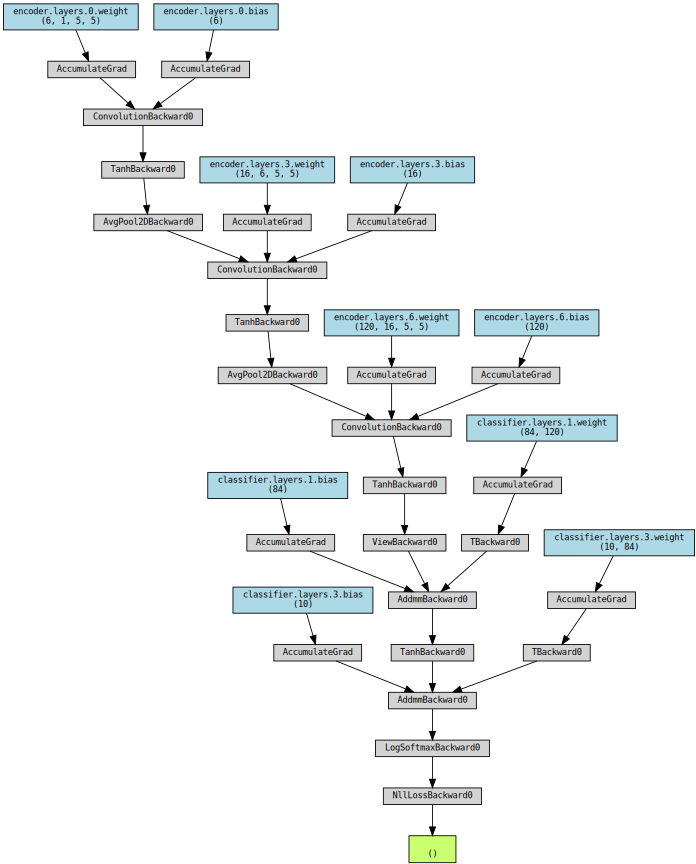

Epoch: 1 / 5, Loss:  1.3179
Epoch: 2 / 5, Loss:  0.4461
Epoch: 3 / 5, Loss:  0.3231
Epoch: 4 / 5, Loss:  0.2656
Epoch: 5 / 5, Loss:  0.2238


In [10]:
EPOCHS = 5
model.train()

for epoch in range(1, EPOCHS + 1):

    # 배치 단위 학습
    running_loss = 0  # 배치가 1개일 때는 필요 없음

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        if epoch == 1 and idx == 0:
            dot = make_dot(loss, params = dict(model.named_parameters()))
            display(dot)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch: {epoch} / {EPOCHS}, Loss: {running_loss / len(train_loader): .4f}")

In [11]:
# 테스트
model.eval()

test_loss = 0
correct = 0

# 학습 비활성화
with torch.no_grad():

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # pred 텐서: 각 이미지에 대해 모델이 예측한 클래스 번호를 담고 있음
        # (Batch Size, 1) 형태
        pred = outputs.argmax(dim = 1)  # keepdim: outputs와 동일한 차원 유지
        correct += (pred == labels).float().sum().item()  # 스칼라 형태로 수정해서 accuracy가 비정상적으로 큰 수가 되는 경우를 방지

# 평균 손실 계산
test_loss /= len(test_loader)

# 정확도 계산
# len(test_loader): 배치의 총 개수, len(test_loader.dataset): 테스트 데이터셋의 총 이미지 개수
# correct: 텐서 형태 -> correct.item(): 스칼라
accuracy = 100 * correct / len(test_loader.dataset)

print(f"Test Loss: {test_loss : .4f}, Accuracy: {accuracy: .4f}")

Test Loss:  0.1957, Accuracy:  94.3400
